# Time Series Analysis with Python
> It's been a while since I've brushed up on my time series forecasting techniques. Time to get on it (this is a work in progress).

- toc: true 
- badges: true
- comments: true
- author: Darpan Ganatra
- categories: [jupyter, python, timeseries]

A couple years ago, I started learning how time series analysis works. It was so very interesting, but I didn't really have time after a few months to dive into it properly. That's what I'll be doing now. Before I get started, note that I'll be following Rob Hydman's excellent book [Forecasting: Principles and Practice](https://otexts.com/fpp2/). This is an attempt to refresh my own memory, and recreate the methods in the book with Python.

# Simple Methods

The basic assumption is that you're aware time series data can be encoded as a sequence: 

$$
y_{1}, y_{2}, \dots , y_{T}
$$

Where $y_{i}$ is the value of the variable we're interested in ($y$) at the time step $i$. 

## Average

This method is as simple as it sounds. If we want to predict the output of a given sequence at the time step $T + 1$ then we take the average of all the values which came before it: 

$$
\hat{y}_{T + 1} = \dfrac{1}{T} \sum_{i = 1}^{T} y_{i}
$$

> Tip: Keep in mind that you'll see something like this $\hat{y}_{T+1 | T}$ which simply means "the predicted value of $y$ at time step $T+1$ given all the previous $T$ timesteps"

In R, you can use `meanf`. In Python (at least with the statsmodels library from what I've seen) we don't have that. So we're going to take a sample dataset of Electrical Equipment Manufacturing as a sample dataset and implement it: 

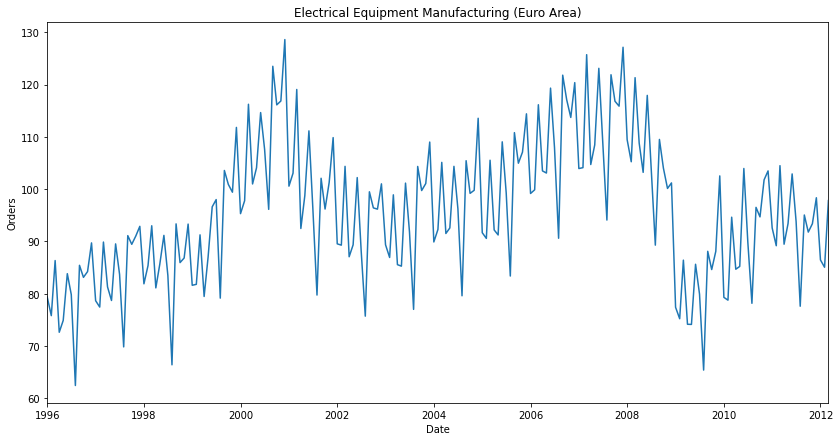

In [1]:
#collapse-hide
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/elecequip.csv")
df.date = pd.DatetimeIndex(df.date, freq='MS')
df = df.set_index('date')

plt.figure(figsize = (14,7))
plt.title("Electrical Equipment Manufacturing (Euro Area)")
plt.plot(df.index, df.value) 
plt.xlim(left = min(df.index), right = max(df.index))
plt.xlabel("Date")
plt.ylabel("Orders")
plt.show()

Now I'll be honest, I created my own **very simple** version of this for Pandas dataframes. This is not something I'd suggest using for anything other than learning: 

In [2]:
def naive_average(y, h=1):
    """
    Args: 
        y: Pandas object with DatetimeIndex
        h: Integer forecast horizon
    """
    try:
        assert isinstance(y.index, pd.core.indexes.datetimes.DatetimeIndex)
    except:
        raise TypeError("y must be of type DatetimeIndex")
    try:
        assert isinstance(h, int)
    except:
        raise TypeError("h must be of type int")

    ts = y.copy(deep=True)

    if ts.index.freq is None:
        inf_freq = pd.infer_freq(ts.index)
        print(
            f"NO FREQUENCY ASSOCIATED WITH INDEX, INFERRING FREQUENCY TO BE: {inf_freq}")
        ts.index = pd.DatetimeIndex(ts.index, freq=inf_freq)

    # Create the extended index
    forecast_index = pd.date_range(
        ts.index[-1], periods=h+1, freq=ts.index.freq, inclusive='right')
    # Get the average
    forecast_name = ts.columns[0]
    forecast_value = np.array([ts[f'{forecast_name}'].mean()])
    forecast_array = np.repeat(a=forecast_value, repeats=h)

    # Create forecast dataframe
    forecast_df = pd.DataFrame(
        forecast_array, index=forecast_index, columns=[forecast_name])
    return pd.concat([ts, forecast_df], axis=0)

Here's an example of our electricity prices forecasted out for 11 months with this method: 

NO FREQUENCY ASSOCIATED WITH INDEX, INFERRING FREQUENCY TO BE: MS


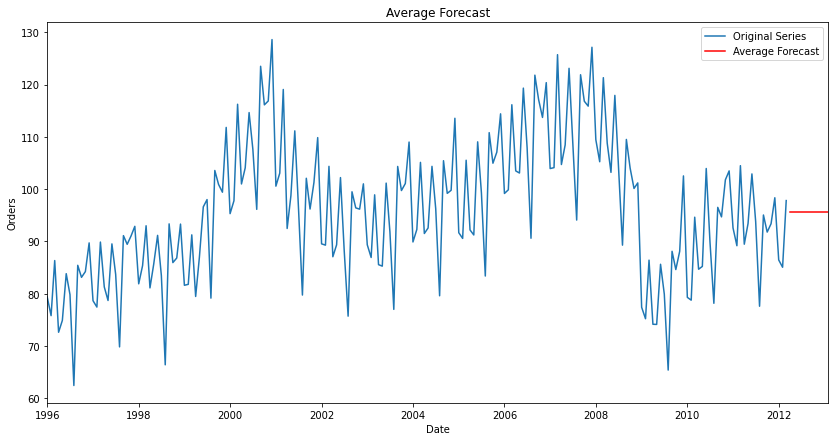

In [3]:
forecast_df = naive_average(df, h = 11)

plt.figure(figsize = (14,7))
plt.title("Average Forecast")
plt.plot(forecast_df[:'2012-03-01'].index, 
         forecast_df[:'2012-03-01'].value, 
         label = 'Original Series')
plt.plot(forecast_df['2012-04-01':].index, 
         forecast_df['2012-04-01':].value, 
         color = 'red', 
         label = 'Average Forecast')
plt.legend()
plt.xlim(left = min(forecast_df.index), right = max(forecast_df.index))
plt.xlabel("Date")
plt.ylabel("Orders")
plt.show()

## Naive

If you thought the averaging method was simple, you're in for a treat because the naive method is even simpler. If you want to predict $\hat{y}_{T+1}$ you simply set it equal to $y_{T}$. That's it. That's the entire thing. For obvious reasons I'm not going to go over this: 

$$
\hat{y}_{T + 1 | T} = y_{T}
$$

## Seasonal Naive 

A bit more interesting is the seasonal naive method, which doesn't take the last value, but the last value of the previous season. A good example of this may be when measuring consumption of electricity, which we know is cyclic (see above). In that case, you may expect the energy consumption today to be similar to the energy consumption last year. In this case, we introduce a new variable, $m$ which is the seasonal period. We can also replace the `1` we've been using (as a way to indicate we want to the forecast for the next time step) with $h$, making it more general. So we can define this as: 

$$
\hat{y}_{T+h | T} = y_{T + 1 - m(k+1)}
$$

Where $k$ is the integer result of $(h-1)/m$

Now I've got to get going, but my post tomorrow will keep going down this road.